# Euclidean routing problem with different start and end points

While this problem is not a TSP, we can quickly solve it using BRKGA as well.

In [1]:
from gasuite.brkga import Termination_criteria, BRKGA_Population_size, BRKGA_TSP
import numpy as np

In [2]:
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt

In [3]:
def eval_full_path_cost(sequence: np.ndarray, point_cloud: np.ndarray, pt0, pt1, norm_type = 2) -> float:
    """ evaluate the total L2 path length of a non-standard TSP problem 
    
    The path in question starts from `pt0`, 
    then walks through each point in `point_cloud` exactly once, 
    and finally arrives at `pt1`.
    
    no checks on the argument, so ensure you know what you are doing when calling this
    """
    all_path_points = np.vstack((pt0.reshape(1,-1), point_cloud[sequence], pt1.reshape(1,-1)))
    cost = np.sum(np.linalg.norm(np.diff(all_path_points, axis=0), axis=1, ord=norm_type))
    return cost.item()

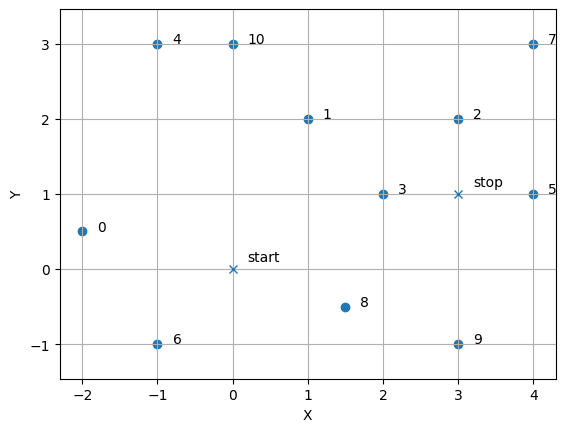

In [4]:
pcd = np.array([
            [-2, 0.5],
            [1, 2],
            [3, 2],
            [2, 1],
            [-1, 3],
            [4, 1],
            [-1, -1],
            [4, 3],
            [1.5, -0.5],
            [3, -1],
            [0, 3]
        ], dtype = np.float32
    )

startAndEnd = np.array((
    (0, 0), # x,y of start
    (3, 1)  # x,y of stop
), dtype=float)

def visualize_problem(ax):
    ax.plot(*startAndEnd.T, ' x')
    plt.text(*(startAndEnd[0]+[0.2, 0.1]), "start")
    plt.text(*(startAndEnd[1]+[0.2, 0.1]), "stop")
    
    ax.scatter(*pcd.T)
    for i, (x,y) in enumerate(pcd):
        plt.text(x+0.2,y+0.01, str(i))
        
    ax.axis('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid()
visualize_problem(plt.subplots()[1])
plt.show()

In [5]:
population_cfg = BRKGA_Population_size(total=100, elite = 4, mutant = 25)
print(population_cfg)
print(" ==> number of crossovers:", population_cfg.xover)

term_criteria = Termination_criteria(
    max_num_gen=500, 
    earlyTerm_improvement_convergence=1e-6, 
    earlyTerm_patience=100)

res = BRKGA_TSP(len(pcd), lambda rank : eval_full_path_cost(rank, pcd, *startAndEnd),
                population_cfg, term_criteria, crossover_bias=0.7,
                rng=np.random.default_rng(12345))

print("Solver exited because", res.reason)
allTimeBest_cost = res.cost_stats.get_all_time_best()
print("Final result", res.optimizer)
print("Number of iterations:", res.cost_stats.num_completed_iterations)
print("Cost of the returned solution:", allTimeBest_cost)

# just to be sure the optimizer is reasonable
assert len(res.optimizer) == len(pcd)
# TODO: check if it's a real permutation

BRKGA_Population_size(total=100, elite=4, mutant=25)
 ==> number of crossovers: 71
Solver exited because Termination_decision.stop_on_sufficient_cost_convergence
Final result [ 6  0  4 10  1  2  7  5  9  8  3]
Number of iterations: 173
Cost of the returned solution: 20.1363443660867


## Learning curve

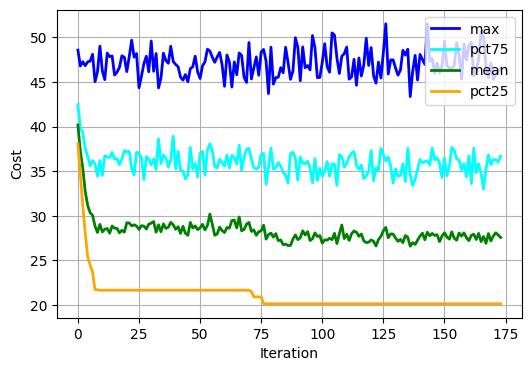

In [6]:
_, ax = plt.subplots(figsize=(6,4))
res.cost_stats.visualize_learning_curve(ax, lw=2)
plt.show()

## The computed path

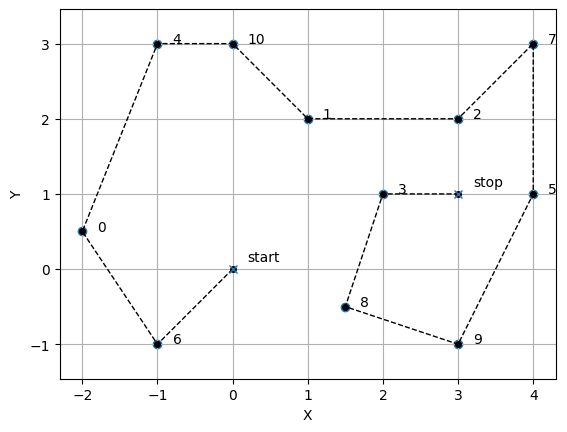

In [7]:
path_xy = np.vstack((
    startAndEnd[0].reshape(1, -1),
    pcd[res.optimizer,...],
    startAndEnd[1].reshape(1, -1)))

ax = plt.subplots()[1]    
ax.plot(*path_xy.T, '--ok', label="Computed", lw=1, ms=4)
visualize_problem(ax)

plt.show()